# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in Varusai and Nguyen, 2018.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon" 
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [1]:
from controlSBML import ControlSBML

import matplotlib.pyplot as plt
import numpy as np

In [2]:
FIGSIZE = (5, 5)
TIMES = np.linspace(0, 2000, 20000)

# Problem Statement

The biological problem we address is controlling the concentration of phosphorylated mTORC1 through phosphorylated insulin. \ccite{varusai_dynamic_2018} describes this in terms of the species pIRS. The system we study has the single input $pIRS$ and the output mTORC1. It turns out that the mTOR system is bistable with respect to the insulin. Thus, our control objective is to regulate the outputs in the high insulin region where V1 $> 4$.
* Outputs: pmTORC1, pmTORC2
* Inputs: V1
* Control problem: regulate pmTORC1, pmTORC2

## mTOR Model

In [3]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"
CTLSB = ControlSBML(URL, figsize=FIGSIZE, times=TIMES, markers=False)  # Specify default value of options

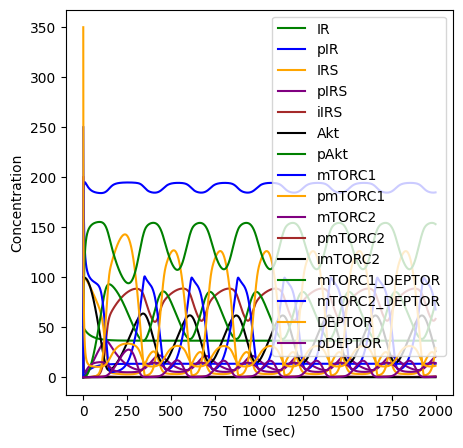

In [4]:
ts = CTLSB.plotModel(ax2=0)

In [5]:
ts.head()

,IR,pIR,IRS,pIRS,iIRS,Akt,pAkt,mTORC1,pmTORC1,mTORC2,pmTORC2,imTORC2,mTORC1_DEPTOR,mTORC2_DEPTOR,DEPTOR,pDEPTOR
miliseconds,,,,,,,,,,,,,,,,
0,50.000000,0.000000,100.000000,0.000000,0.000000e+00,100.000000,0.000000,250.000000,0.000000e+00,200.000000,0.000000,0.0,0.000000,0.000000,350.000000,0.000000
100,49.965572,0.034428,99.999885,0.000115,4.022952e-11,99.999987,0.000013,242.024306,2.929874e-08,159.391112,0.000263,0.0,7.975694,40.608625,301.415680,0.000001
200,49.931259,0.068741,99.999542,0.000458,1.122740e-09,99.999902,0.000098,235.280182,3.989801e-07,130.785704,0.000968,0.0,14.719817,69.213329,266.066846,0.000008
300,49.897058,0.102942,99.998971,0.001029,7.487933e-09,99.999689,0.000311,229.434826,1.731502e-06,109.675904,0.002003,0.0,20.565172,90.322093,239.112710,0.000026
400,49.862969,0.137031,99.998174,0.001826,2.786260e-08,99.999306,0.000694,224.274703,4.723101e-06,93.545355,0.003282,0.0,25.725293,106.451362,217.823289,0.000056


## System Definition

In [6]:
INPUT_NAME = "pIRS"
#INPUT_NAME = "IRS"
OUTPUT_NAME = "pmTORC1"

<Axes: xlabel='miliseconds'>

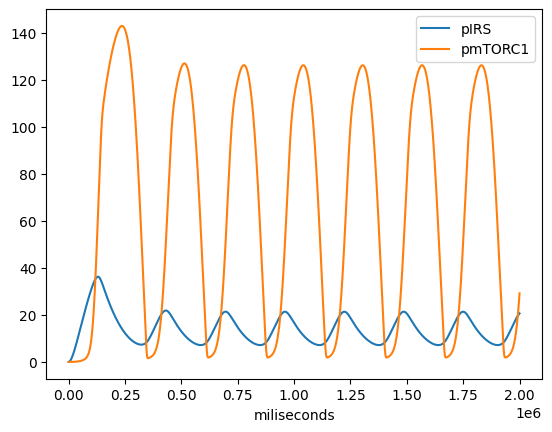

In [7]:

df = ts[[INPUT_NAME, OUTPUT_NAME]]
seconds = np.array(df.index)/1000
df.index = seconds
df.plot()

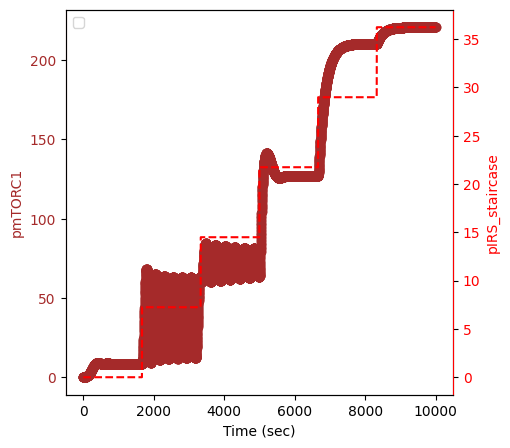

In [8]:
# Define the system and plot response over a controlled range
CTLSB = ControlSBML(URL, figsize=FIGSIZE, input_names=[INPUT_NAME], output_names=[OUTPUT_NAME],
                   times=np.linspace(0, 10000, 10000), markers=False, sign=-1)
_, builder = CTLSB.plotStaircaseResponse()

Clearly, the effect of theinput, pIRS, is effective over only a subset of the range of pIRS. So, we focus on the interval [20, 25].

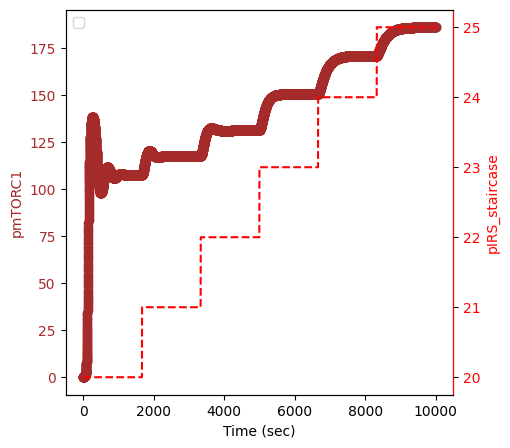

In [9]:
_, builder = CTLSB.plotStaircaseResponse(initial_value=20, final_value=25)

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

# System Identification

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Possible numerical instability: max abs residual is 27.124656



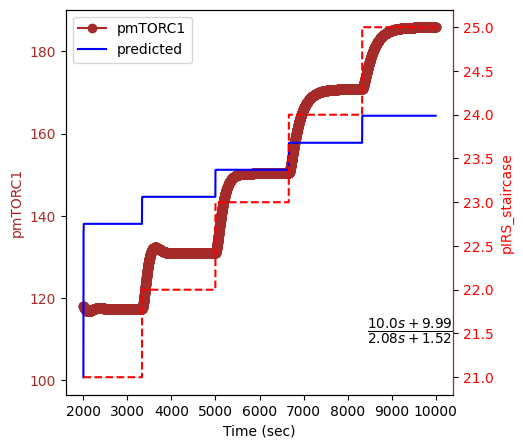

In [10]:
_ = CTLSB.plotTransferFunctionFit(figsize=FIGSIZE, num_numerator=2, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000)

In [11]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([9.99999692, 9.98564205]), array([2.08420664, 1.51876453]))

In [12]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-0.72870151+0.j]), array([-0.99856451+0.j]))

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

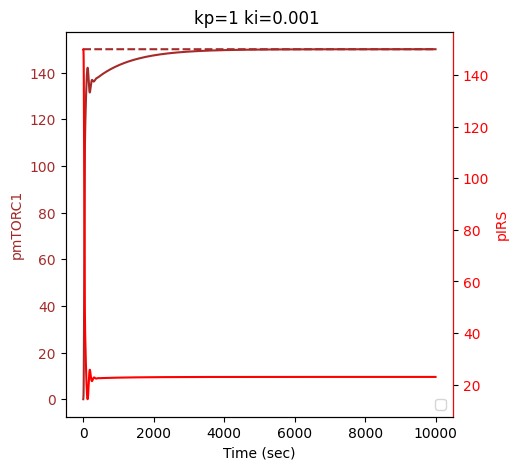

In [24]:
_ = CTLSB.plotClosedLoop(setpoint=150, kp=1, ki=0.001, kf=None)

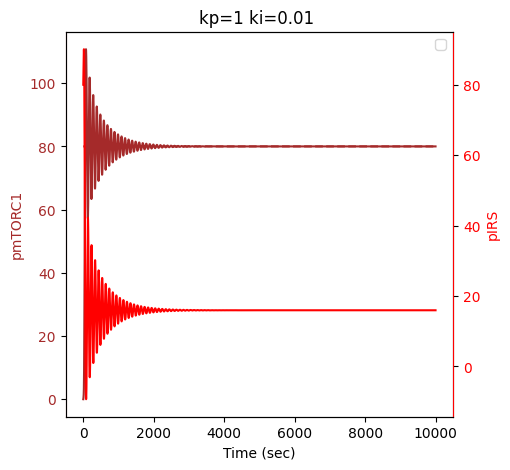

In [25]:
_ = CTLSB.plotClosedLoop(setpoint=80, kp=1, ki=0.01, kf=None)

We are able to simulate the closed loop system, but it's not easy to find design parameters such that: (a) settling times are short; (b) there is not overshoot; and (c) all concentrations are non-negative.

**Notes**
1. Need to use positive feedback. Not clear from the controlability curves.
2. Introducing even a little I behavior makes the controller worse.
3. There is a multimodal behavior of the network that radically changes the long term steady state values. Could this be analyzed by decomposing the system to have multiple tandem controllers. The first controls the effect of IR on pIRS; the second controls the effect of pIRS on pmTORC1.

# Design and Evaluation

Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 119.293, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 129.17, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 164.934, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 120.336, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 135.577, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 191.663, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 119.408, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Modu

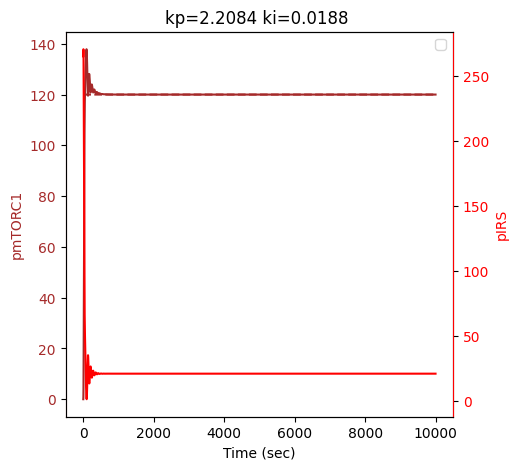

In [17]:
ts, builder = CTLSB.plotDesign(setpoint=120, kp_spec=True, ki_spec=True, kf_spec=False, num_restart=10)

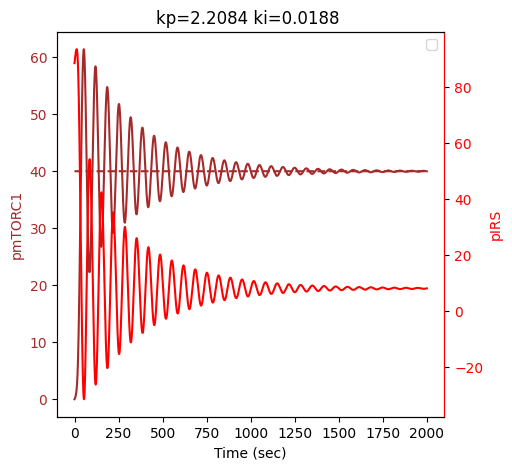

In [20]:
_ = CTLSB.plotClosedLoop(setpoint=40, kp=2.2084, ki=0.0188, times=np.linspace(0, 2000, 20000))

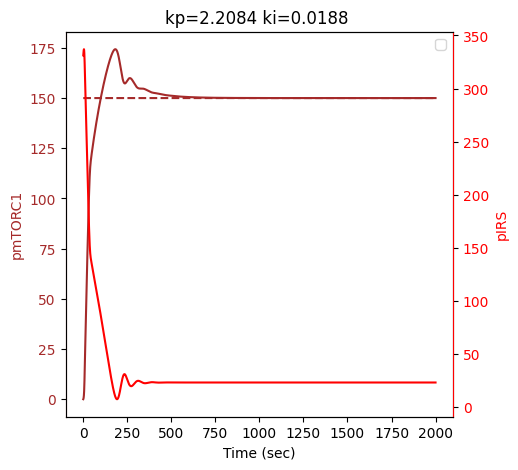

In [21]:
_ = CTLSB.plotClosedLoop(setpoint=150, kp=2.2084, ki=0.0188, times=np.linspace(0, 2000, 20000))

# Issues

1. Handle longer time strings on x-axis